In [190]:
%matplotlib inline

In [1]:
import pandas as pd
import os
import re
from Bio import SeqIO

os.chdir('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/blastp_on_p')
"""
Run on command line the following.
blastp -query Pst_E104_v1_p_ctg.anno.RepaseTPSI_filtered.protein.fa -db Pst_E104_v1_h_ctg.anno.RepaseTPSI_filtered.protein.fa  -outfmt 6 -evalue 1e-5 -num_threads 6 > Pst_E104_v1_p_ctg.anno.RepaseTPSI_filtered.protein.p_on_h.blast.alloutfmt6 &
blastp -query Pst_E104_v1_h_ctg.anno.RepaseTPSI_filtered.protein.fa  -db Pst_E104_v1_p_ctg.anno.RepaseTPSI_filtered.protein.fa  -outfmt 6 -evalue 1e-5 -num_threads 6 > Pst_E104_v1_h_ctg.anno.RepaseTPSI_filtered.protein.h_on_p.blast.alloutfmt6&
"""

os.listdir()
hit_df =''
files = os.listdir()
outfmt6 = [x for x in files if x.endswith('blast.alloutfmt6') and 'anno' in x]
outfmt6.sort()
print(outfmt6)
fa_files = [x for x in files if x.endswith('RepaseTPSI_filtered.protein.fa')]
fa_files.sort()
print(fa_files)

#The next block should pull in both the initial protein and the blast df.
#The initial protein should become a dataframe that contains proteins sequence name and length.
#This df should be merged with the blast df in a way that proteins without hit should get NA values. 
#Once this is done make two arrays with [p, h], sort this and compare, pull out everything that is identical, and lable it with a new column reverse blast Yes/No.
#Pull out YES and see if they are enriched/depelted in something. NOs need to be checked for high coverage in ph vs h/p mapping and levels of heterozycosity + h on p mapping mappings. 

#read in protein ids for p and h contigs and store names in a list in a dict with unique key id [first part of
#file name].
fa_protein_dict = {}
fa_protein_length_dict = {}
for file in fa_files:
    seq_list = []
    length_list =[]
    for seq in SeqIO.parse(open(file), 'fasta'):
        seq_list.append(seq.id)
        length_list.append(len(seq.seq))
    key_name = file.split('.')[0]
    fa_protein_dict[key_name] = seq_list
    fa_protein_length_dict[key_name] = dict(zip(seq_list, length_list))

#generate df dict of blast output and filter blast output
header = ['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery', 'StopQuery', 'StartTarget',\
              'StopTarget', 'e-value','BitScore']
outfmt6_dict ={} #contains the filtered values
outfmt6_dict_all = {} #contains the unfiltered blast hits e.g. low % identity and low query coverage
#match_dict = {} #get best hits in match_dict[p_protein] = h_protein
hit_df = pd.DataFrame(columns=['p_protein', 'h_protein'])
for outfile in outfmt6:
    key_name =  outfile.split('.')[0]
    df = ''
    df = pd.read_csv(outfile, header = None, names = header, sep='\t')
    #add the query length using to the df using the length dict generated before
    df["QLgth"] = df["Query"].apply(lambda x: fa_protein_length_dict[key_name][x]) 
    df["QCov"] = df['AlnLgth']/df['QLgth']*100 #calculate the % coverage for each querry
    outfmt6_dict_all[key_name] = df
    df = df[(df['QCov'] > 30) & (df['PctID'] > 50) ] #define paralogous as Query coverage > 30% and PctID > 50
    #this could be more dynamic and the outfmt of blast AlnLngthPct and they greater than 60%
    groups = df.groupby(by='Query')
    #now filter the dataframe by the smallest e-value for each group == Query
    df_filtered = groups.apply(lambda g: g[g['e-value'] == g['e-value'].min()]) 
    df_filtered = df_filtered.reset_index(drop=True)
    #in case there is a blast query that hits the same subject twice with the same minimal e-value
    df_filtered = df_filtered.drop_duplicates(subset=['Query', 'Target'], keep ='last')
    outfmt6_dict[key_name] = df_filtered
    if 'p_ctg' in key_name:
        df_filtered['h_protein'] = df_filtered['Target']
        df_filtered['p_protein'] = df_filtered['Query']
    if 'h_ctg' in key_name:
        df_filtered['h_protein'] = df_filtered['Query']
        df_filtered['p_protein'] = df_filtered['Target']
    hit_df = pd.concat([hit_df, df_filtered.loc[:, ['p_protein', 'h_protein']]])

#duplicates are besties as they are entered twice from both outfmt

bestie_df = hit_df[hit_df.duplicated(keep='first')]

bestie_df.to_csv(list(outfmt6_dict.keys())[0][:-6] + '.besties.txt', sep='\t', header=None, index=None)
bestie_df['p_protein'].to_csv(list(outfmt6_dict.keys())[0] + '.besties.txt', sep='\t', header=None, index=None)
bestie_df['h_protein'].to_csv(list(outfmt6_dict.keys())[1] + '.besties.txt', sep='\t', header=None, index=None)


#this is pulling out the no blast hits at all. Should be a subset of no_besties
no_hits ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_hits[key] = set(fa_protein_dict[key]) - set(outfmt6_dict_all[key]['Query'].unique())
        pd.DataFrame(list(no_hits[key])).to_csv(key + '.p_proteins.no_blast_hit.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_hits[key] = set(fa_protein_dict[key]) - set(outfmt6_dict_all[key]['Query'].unique())
        pd.DataFrame(list(no_hits[key])).to_csv(key + '.h_proteins.no_blast_hit.txt', sep='\t', header=None, index=None)

no_hits_filtered ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_hits_filtered[key] = set(fa_protein_dict[key]) - set(outfmt6_dict[key]['Query'].unique())
        pd.DataFrame(list(no_hits_filtered[key])).to_csv(key + '.p_proteins.no_filtered_blast_hit.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_hits_filtered[key] = set(fa_protein_dict[key]) - set(outfmt6_dict[key]['Query'].unique())
        pd.DataFrame(list(no_hits_filtered[key])).to_csv(key + '.h_proteins.no_filtered_blast_hit.txt', sep='\t', header=None, index=None)
        

#this is now pulling out the besties
no_bestie ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_bestie[key] = set(fa_protein_dict[key]) - set(bestie_df['p_protein'])
        pd.DataFrame(list(no_bestie[key])).to_csv(key + '.p_proteins.no_besties.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_bestie[key] = set(fa_protein_dict[key]) - set(bestie_df['h_protein'])
        pd.DataFrame(list(no_bestie[key])).to_csv(key + '.h_proteins.no_besties.txt', sep='\t', header=None, index=None)        
        
_len_out = 0
_len_pro = 0
for x in fa_protein_dict.keys():
    _len_pro += len(fa_protein_dict[x])
    _len_out += len(no_bestie[x])
_len_out += (len(bestie_df))*2 - bestie_df.duplicated(subset="p_protein", keep='last').sum() \
- bestie_df.duplicated(subset="h_protein", keep='last').sum()
_len_out == _len_pro


['Pst_E104_v1_h_ctg.anno.RepaseTPSI_filtered.protein.h_on_p.blast.alloutfmt6', 'Pst_E104_v1_p_ctg.anno.RepaseTPSI_filtered.protein.p_on_h.blast.alloutfmt6']
['Pst_E104_v1_h_ctg.anno.RepaseTPSI_filtered.protein.fa', 'Pst_E104_v1_p_ctg.anno.RepaseTPSI_filtered.protein.fa']


True

In [2]:
_len_out = 0
_len_pro = 0
for x in fa_protein_dict.keys():
    _len_pro += len(fa_protein_dict[x])
    _len_out += len(no_bestie[x])
    print("Out of %i %i have no reciprocal blast hit for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_bestie[x]),x, (len(no_bestie[x])/len(fa_protein_dict[x])*100) ))
    print("Out of %i %i have no blast hit at all for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_hits[x]),x, (len(no_hits[x])/len(fa_protein_dict[x])*100) ))
    print("Out of %i %i have no blast hit after filtering by AlnLght and QCov for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_hits_filtered[x]),x, (len(no_hits_filtered[x])/len(fa_protein_dict[x])*100) ))
_len_out += (len(bestie_df))*2 - bestie_df.duplicated(subset="p_protein", keep='last').sum() \
- bestie_df.duplicated(subset="h_protein", keep='last').sum()
_len_out == _len_pro

Out of 14321 2496 have no reciprocal blast hit for Pst_E104_v1_h_ctg making it 17.43 percent.
Out of 14321 333 have no blast hit at all for Pst_E104_v1_h_ctg making it 2.33 percent.
Out of 14321 542 have no blast hit after filtering by AlnLght and QCov for Pst_E104_v1_h_ctg making it 3.78 percent.
Out of 15930 4261 have no reciprocal blast hit for Pst_E104_v1_p_ctg making it 26.75 percent.
Out of 15930 1236 have no blast hit at all for Pst_E104_v1_p_ctg making it 7.76 percent.
Out of 15930 2134 have no blast hit after filtering by AlnLght and QCov for Pst_E104_v1_p_ctg making it 13.40 percent.


True

In [3]:
def blast_outfmt6_to_bed(x):
    blast_fo = open(x, 'r')
    blast_lines = blast_fo.readlines()
    bed_file_name = x + '.bed'
    bed_fo = open(bed_file_name, 'w+')
    for l in blast_lines:
        content = l.split('\t')
        if int(content[8]) - int(content[9]) < 1:
            print(content[1], int(content[8]) -1, content[9], content[0], content[10], "+", sep="\t", file=bed_fo) 
        else:
            print(content[1], int(content[9]) -1, content[8],  content[0], content[10], "-", sep = "\t", file=bed_fo)
    blast_fo.close()
    bed_fo.close()

In [4]:
from Bio import SeqIO
import os
import pandas as pd
import re

folder_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/blastp_on_p/'

no_besties = [x for x in os.listdir(folder_p) if x.endswith('no_besties.txt')]
gene_files = [x for x in os.listdir(folder_p) if '.gene.' in x and '.fa' in x]
no_besties.sort()
gene_files.sort()
no_bestie_dict = {}

#simply pulls in the gene sequences of missing besties
for no_b, gene_file in zip(no_besties, gene_files):
    no_bestie_list = pd.read_csv(folder_p+no_b, header=None, sep='\t')[0].tolist()
    key = no_b.split('.')[0]
    no_bestie_dict[key] = no_bestie_list
    no_bestie_list = [x.replace('evm.model', 'evm.TU') for x in no_bestie_list]
    no_bestie_seq = []
    for seq in SeqIO.parse(open(folder_p + gene_file), 'fasta'):
        if seq.id in no_bestie_list:
            no_bestie_seq.append(seq)
    out_f = folder_p + no_b[:-3].replace('protein', 'gene') + 'fa'
    f_handle = open(out_f,'w') #need to generate handle for writing and
    SeqIO.write(no_bestie_seq, f_handle, 'fasta')
    f_handle.close() #closing file afterwards again

gene_files_no_besties = [x for x in os.listdir(folder_p) if x.endswith('_genes.no_besties.fa')]
blast_db_nt = [x for x in os.listdir(folder_p) if x.endswith('_ctg.fa')]
gene_files_no_besties.sort()
blast_db_nt.sort()

os.chdir(folder_p)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[1], gene_files_no_besties[0],gene_files_no_besties[0]))
!blastn -db {blast_db_nt[1]} -query {gene_files_no_besties[0]}  -outfmt 6 -evalue 1e-10 -num_threads 1 \
> {gene_files_no_besties[0]}.outfmt6


in_file =gene_files_no_besties[0]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[0], gene_files_no_besties[1],gene_files_no_besties[1]))
!blastn -db {blast_db_nt[0]} -query {gene_files_no_besties[1]}  -outfmt 6 -evalue 1e-10 -num_threads 1 \
> {gene_files_no_besties[1]}.outfmt6


in_file =gene_files_no_besties[1]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

blastn -db Pst_E104_v1_p_ctg.fa -query -Pst_E104_v1_h_ctg.h_genes.no_besties.fa > Pst_E104_v1_h_ctg.h_genes.no_besties.fa.outfmt6
blastn -db Pst_E104_v1_h_ctg.fa -query -Pst_E104_v1_p_ctg.p_genes.no_besties.fa > Pst_E104_v1_p_ctg.p_genes.no_besties.fa.outfmt6


In [5]:
#blast no_filtered_blast_hits genes against opposite haplotyp at the gene level
folder_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/blastp_on_p/'

no_filtered_blast = [x for x in os.listdir(folder_p) if x.endswith('no_filtered_blast_hit.txt')]
gene_files = [x for x in os.listdir(folder_p) if '.gene.' in x and '.fa' in x]
no_filtered_blast.sort()
gene_files.sort()
no_filtered_blast_dict = {}
gene_files = gene_files[:2]

#simply pulls in the gene sequences of missing besties
for no_b, gene_file in zip(no_filtered_blast, gene_files):
    print(no_b)
    no_filtered_blast_list = pd.read_csv(folder_p+no_b, header=None, sep='\t')[0].tolist()
    key = no_b.split('.')[0]
    no_filtered_blast_dict[key] = no_filtered_blast_list
    no_filtered_blast_list = [x.replace('evm.model', 'evm.TU') for x in no_filtered_blast_list]
    no_filtered_blast_seq = []
    for seq in SeqIO.parse(open(folder_p + gene_file), 'fasta'):
        if seq.id in no_filtered_blast_list:
            no_filtered_blast_seq.append(seq)
    out_f = ''
    out_f = folder_p + no_b[:-3].replace('protein', 'gene') + 'fa'
    f_handle = open(out_f,'w') #need to generate handle for writing and
    SeqIO.write(no_filtered_blast_seq, f_handle, 'fasta')
    f_handle.close() #closing file afterwards again

gene_files_no_filtered_blast = [x for x in os.listdir(folder_p) if x.endswith('_genes.no_filtered_blast_hit.fa')]
blast_db_nt = [x for x in os.listdir(folder_p) if x.endswith('_ctg.fa')]
gene_files_no_filtered_blast.sort()
blast_db_nt.sort()

os.chdir(folder_p)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[1], gene_files_no_filtered_blast[0],gene_files_no_filtered_blast[0]))
!blastn -db {blast_db_nt[1]} -query {gene_files_no_filtered_blast[0]}  -outfmt 6 -evalue 1e-10 -num_threads 1 \
> {gene_files_no_filtered_blast[0]}.outfmt6


in_file =gene_files_no_filtered_blast[0]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[0], gene_files_no_filtered_blast[1],gene_files_no_filtered_blast[1]))
!blastn -db {blast_db_nt[0]} -query {gene_files_no_filtered_blast[1]}  -outfmt 6 -evalue 1e-10 -num_threads 1 \
> {gene_files_no_filtered_blast[1]}.outfmt6


in_file =gene_files_no_filtered_blast[1]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

Pst_E104_v1_h_ctg.h_proteins.no_filtered_blast_hit.txt
Pst_E104_v1_p_ctg.p_proteins.no_filtered_blast_hit.txt
blastn -db Pst_E104_v1_p_ctg.fa -query -Pst_E104_v1_h_ctg.h_genes.no_filtered_blast_hit.fa > Pst_E104_v1_h_ctg.h_genes.no_filtered_blast_hit.fa.outfmt6
blastn -db Pst_E104_v1_h_ctg.fa -query -Pst_E104_v1_p_ctg.p_genes.no_filtered_blast_hit.fa > Pst_E104_v1_p_ctg.p_genes.no_filtered_blast_hit.fa.outfmt6


In [258]:
#make a dict of df out of the _genes.no_filtered_blast_hit.fa.outfmt6.bed files this can be used later on for
#summary purposes and such
nfb_gene_blast_bed_df_filtered_dict = {}
for file in nfb_gene_blast_bed_df_filtered:
    nfb_gene_blast_bed_df_filtered_dict[file.split('.')[0]] = pd.read_csv(file, header = None, sep='\t')

In [32]:
!cut -f4 Pst_E104_v1_p_ctg.p_genes.no_filtered_blast_hit.fa.outfmt6.bed | sort | uniq | wc -l

677


In [34]:
!cut -f4 Pst_E104_v1_h_ctg.h_genes.no_filtered_blast_hit.fa.outfmt6.bed | sort | uniq | wc -l

442


In [8]:
#here track what happens with the no_besties hit. Do they not have protein blast hits? How many of the no protein 
#blast hits have not gene blast hit?
#this needs to include some folder tracking of gene.no_besties.fa that hits nothing significant 
#no_bbb in - no_bbb out = no_hits at all
no_gene_hits = {}
no_besties_blast_nt_bed = [x for x in os.listdir() if x.endswith('no_besties.fa.outfmt6.bed')]
no_besties_blast_nt_bed.sort()
for no_bbb, protein_blast in zip(no_besties_blast_nt_bed,outfmt6):
    no_bbb_no_protein_blast_df =''
    no_bbb_df_header = ['Contig', 'start', 'end', 'blast_query', 'e-value', 'strand']
    no_bbb_df = pd.read_csv(folder_p+no_bbb, header=None, names=no_bbb_df_header,  sep='\t')
    protein_blast_df = pd.read_csv(folder_p+protein_blast, header=None, sep='\t')
    no_bbb_df['protein_id'] = no_bbb_df['blast_query'].str.replace('evm.TU', 'evm.model')
    #this below is most likely correct ignores the fact that some no_bbb genes might have hit nothing
    #at all on the gene level
    no_bbb_no_protein_blast_df = no_bbb_df[~no_bbb_df['protein_id'].isin(protein_blast_df[0])]
    #these are the no_besties that didn't hit anything at the gene level
    key =''
    key = no_bbb.split('.')[0]
    no_gene_hits[key] = set(no_bestie_dict[key]) - set(no_bbb_df['protein_id'].unique())
    pd.DataFrame(list(no_gene_hits[key])).to_csv(key + '.gene.no_genome_blast_hit.txt', sep='\t', header=None, index=None)
    blast_p_no_bestie =''
    blast_p_no_bestie = len(no_bbb_df[no_bbb_df['protein_id'].isin(protein_blast_df[0])]['blast_query'].unique())
    print('This %i out of %i no_besties of %s had a blast hit which was not RBH' % \
          (blast_p_no_bestie, len(no_bestie_dict[key]),no_bbb.split('.')[0]))
    print('This %i out of %i no_besties of %s have no blast hit gene vs. other haplome' % \
         (len(no_gene_hits[key]),len(no_bestie_dict[key]),no_bbb.split('.')[0]))
    print("No gene hits that have a protein hit", len(set(no_gene_hits[key])- set(no_hits[key])), key)
    groups = no_bbb_no_protein_blast_df.groupby(by='blast_query')
    #now filter the dataframe by the smallest e-value for each group == blast_hit
    df_filtered = groups.apply(lambda g: g[g['e-value'] == g['e-value'].min()])
    df_filtered = df_filtered.reset_index(drop=True)
    df_filtered.iloc[:,0:6].to_csv(folder_p+no_bbb[:-4]+'.filteredbesthits.bed', sep='\t', header=None, index=None)

This 2047 out of 2496 no_besties of Pst_E104_v1_h_ctg had a blast hit which was not RBH
This 170 out of 2496 no_besties of Pst_E104_v1_h_ctg have no blast hit gene vs. other haplome
No gene hits that have a protein hit 116 Pst_E104_v1_h_ctg
This 2158 out of 4261 no_besties of Pst_E104_v1_p_ctg had a blast hit which was not RBH
This 1693 out of 4261 no_besties of Pst_E104_v1_p_ctg have no blast hit gene vs. other haplome
No gene hits that have a protein hit 867 Pst_E104_v1_p_ctg


In [9]:
#all primary proteins no hit need to be split up into pwh and pwoh
p_contig_list = []
h_contig_list = []
for seq in SeqIO.parse('Pst_E104_v1_h_ctg.fa', 'fasta'):
    h_contig_list.append(seq.id)
for seq in SeqIO.parse('Pst_E104_v1_p_ctg.fa', 'fasta'):
    p_contig_list.append(seq.id)

In [10]:
pwh_set = set([x[0:11].replace('h','p') for x in h_contig_list])
pwoh_set = set(p_contig_list) - pwh_set
print("P_contigs with h_contig are %i and without %i" % (len(pwh_set), len(pwoh_set)))

P_contigs with h_contig are 102 and without 74


In [11]:
def pwh_filter (x):
    p_contig = x.split('.')[2]
    if p_contig in pwh_set:
        return 1
    else:
        return 0

In [12]:
fa_protein_dict['Pst_E104_v1_p_ctg_pwh']= [x for x in fa_protein_dict['Pst_E104_v1_p_ctg'] if x.split('.')[2] in pwh_set]
fa_protein_dict['Pst_E104_v1_p_ctg_pwoh']= [x for x in fa_protein_dict['Pst_E104_v1_p_ctg'] if x.split('.')[2] in pwoh_set]
print(len(fa_protein_dict['Pst_E104_v1_p_ctg_pwh']), len(fa_protein_dict['Pst_E104_v1_p_ctg_pwoh']), len (fa_protein_dict['Pst_E104_v1_p_ctg']))


15303 627 15930


In [26]:
p_txt = [x for x in os.listdir(folder_p) if x.split('.')[0] == 'Pst_E104_v1_p_ctg' and x.endswith('.txt')\
        and not 'pwh' in x and not 'pwoh' in x]

In [27]:
p_txt

['Pst_E104_v1_p_ctg.gene.no_genome_blast_hit.txt',
 'Pst_E104_v1_p_ctg.p_proteins.no_blast_hit.txt',
 'Pst_E104_v1_p_ctg.besties.txt',
 'Pst_E104_v1_p_ctg.p_proteins.no_filtered_blast_hit.txt',
 'Pst_E104_v1_p_ctg.p_proteins.no_besties.txt']

In [30]:
#filter and summarize the p results based on pwh and pwoh 
p_txt = [x for x in os.listdir(folder_p) if x.split('.')[0] == 'Pst_E104_v1_p_ctg' and x.endswith('.txt')\
        and not 'pwh' in x and not 'pwoh' in x and not x.endswith('besties.txt')]
for x in p_txt:
    #print(x)
    df_p = pd.read_csv(x, header=None, sep='\t')
    #df_p.head()
    df_p['pwh'] = df_p[0].apply(pwh_filter)
    df_p[df_p['pwh'] == 1].to_csv(x[:-4]+'pwh.txt', sep ='\t', header=None, index=None)
    df_p[df_p['pwh'] == 0].to_csv(x[:-4]+'pwoh.txt', sep ='\t', header=None, index=None)
    print ('For pwh:')
    print('For this condition %s %i proteins out of %i (%.2f) are affected for pwh'% \
          (x, sum(df_p['pwh']),len(fa_protein_dict['Pst_E104_v1_p_ctg_pwh']), \
           sum(df_p['pwh'])/len(fa_protein_dict['Pst_E104_v1_p_ctg_pwh'])*100 ))
    print ('For pwoh:')e
    print('For this condition %s %i proteins out of %i (%i) are affected for pwoh'% \
         (x, len(df_p['pwh']) - sum(df_p['pwh']),len(fa_protein_dict['Pst_E104_v1_p_ctg_pwoh']),\
        (len(df_p['pwh']) - sum(df_p['pwh']))/len(fa_protein_dict['Pst_E104_v1_p_ctg_pwoh'])*100 ))
     

from Bio import SeqIO
import os

os.chdir('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/blastp_on_p')
len_pwh = 0
len_pwoh = 0
for seq in SeqIO.parse('Pst_E104_v1_p_ctg.fa', 'fasta'):
    if seq.id in pwh_set:
        len_pwh = len_pwh + len(seq.seq)
    if seq.id in pwoh_set:
        len_pwoh = len_pwoh + len(seq.seq)
print("Lenght of pwoh %i, lenght of pwo %i, total length p %i" %(len_pwh,len_pwoh,len_pwh+len_pwoh ))

Pst_E104_v1_p_ctg.gene.no_genome_blast_hit.txt
For pwh:
For this condition Pst_E104_v1_p_ctg.gene.no_genome_blast_hit.txt 1443 proteins out of 15303 (9.43) are affected for pwh
For pwoh:
For this condition Pst_E104_v1_p_ctg.gene.no_genome_blast_hit.txt 250 proteins out of 627 (39) are affected for pwoh
Pst_E104_v1_p_ctg.p_proteins.no_blast_hit.txt
For pwh:
For this condition Pst_E104_v1_p_ctg.p_proteins.no_blast_hit.txt 1096 proteins out of 15303 (7.16) are affected for pwh
For pwoh:
For this condition Pst_E104_v1_p_ctg.p_proteins.no_blast_hit.txt 140 proteins out of 627 (22) are affected for pwoh
Pst_E104_v1_p_ctg.p_proteins.no_filtered_blast_hit.txt
For pwh:
For this condition Pst_E104_v1_p_ctg.p_proteins.no_filtered_blast_hit.txt 1866 proteins out of 15303 (12.19) are affected for pwh
For pwoh:
For this condition Pst_E104_v1_p_ctg.p_proteins.no_filtered_blast_hit.txt 268 proteins out of 627 (42) are affected for pwoh
Lenght of pwoh 79847369, lenght of pwo 4178824, total length p 840

In [14]:
def same_contig_blast(x,y):
    '''Function that checks if the blast hit in columne y is on the same contig as the the query sequence in
    column y.
    '''
    q_contig = x.split('.')[2].split('_')[1]
    hit_contig = y.split('_')[1]
    if q_contig == hit_contig:
        return True
    else:
        return False

In [134]:
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
nfb_gene_blast_bed = [x for x in os.listdir(folder_p) if x.endswith('no_filtered_blast_hit.fa.outfmt6.bed')]
nfb_gene_blast_bed.sort()
protein_dict_nfb_bhits = {}
protein_dict_nfb = {} #get a list of all proteins of nfb that don't have a hit when blasted at the gene level too
#get the fasta genome files
tmp_genome_files = ['Pst_E104_v1_p_ctg.fa', 'Pst_E104_v1_h_ctg.fa']
protein_fa_files = [x for x in os.listdir(folder_p) if x.endswith('anno.RepaseTPSI_filtered.protein.fa')]
for bed_file in nfb_gene_blast_bed:
    print('This %s is the current bed file being processed' % (bed_file))
    nfb_gene_blast_bed_df =''
    nfb_gene_blast_bed_df = pd.read_csv(bed_file, header=None, sep='\t' )
    #now add another column to the dateframe that stats if the hit and query are on the same contig
    nfb_gene_blast_bed_df['Same_contig'] = nfb_gene_blast_bed_df[3].combine(nfb_gene_blast_bed_df[0], func=same_contig_blast)
    #initialize some temporary df for filtering
    tmp_same_contig_df =''
    tmp_best_hits_df =''
    tmp_groups =''
    tmp_best_hits_filtered =''
    #get all blast hits that are on the same contig
    tmp_same_contig_df = nfb_gene_blast_bed_df[nfb_gene_blast_bed_df['Same_contig'] == True]
    #get the best remaining blast hit(s)
    tmp_best_hits_df = nfb_gene_blast_bed_df[nfb_gene_blast_bed_df['Same_contig'] == False].sort_values(by=[3,4])
    tmp_groups = tmp_best_hits_df.groupby(by=3)
    #now filter the dataframe by the smallest e-value for each group == Query/3
    tmp_best_hits_df_filtered = tmp_groups.apply(lambda g: g[g[4] == g[4].min()]) 
    tmp_best_hits_df_filtered = tmp_best_hits_df_filtered.reset_index(drop=True)
    nfb_gene_blast_bed_df_filtered = ''
    nfb_gene_blast_bed_df_filtered = pd.concat([tmp_best_hits_df_filtered, tmp_same_contig_df]).sort_values(by=[3,4]).reset_index(drop=True)
    #now get the loop through the df. pull out the protein sequences and corresponding hits. save them to new folders.
    #extend the script. 
    #get all the blasted sequences that had a hit == unique querries
    tmp_queries = ''
    tmp_queries = nfb_gene_blast_bed_df_filtered[3].unique()
    #get all the protein sequences in a dictionary with protein ID being the key and the values being a SeqIO object
    #get the fasta genome files
    tmp_genome_file = [x for x in tmp_genome_files if not x.startswith(bed_file.split('.')[0])][0]
    genome_fa = ''
    genome_fa = pysam.FastaFile(tmp_genome_file)
    tmp_queries_id = [x.replace('TU', 'model') for x in tmp_queries]
    tmp_protein_fa_file = [x for x in protein_fa_files if x.startswith(bed_file.split('.')[0])][0]
    for seq in SeqIO.parse(open(tmp_protein_fa_file), 'fasta'):
            if seq.id in tmp_queries_id:
                protein_dict_nfb[seq.id] = seq
    #add this tmp_protein_dict_nfb to the full protein dict to keep track
    #check why only one file gets processed.
    
    
    #make a dict that gets the blast hit sequences in +30kb each side for alignments of protein sequences on top of them. 
    #The value of this dict will be a list of SeqIO objects
    
    tmp_list = [] #tmp_list to save the SeqIO objects for the blast hits in
    print(len(tmp_queries))
    for query in tmp_queries:
        #print(query)
        tmp_list = []
        tmp_df = nfb_gene_blast_bed_df_filtered[nfb_gene_blast_bed_df_filtered[3] == query]
        #do groupby instead here on columns one. Take min of column 1 and max of column 2 as start/stop +-
        #this avoids to mess around with mutliple hits on the same contig
        tmp_hit = tmp_df[0].unique()
        for hit in tmp_hit:
            tmp_df_2 = tmp_df[tmp_df[0] == hit]
            start = tmp_df_2[1].min() - 30000
            if start < 1:
                start = 1
            end = tmp_df_2[2].max() + 30000
            seq = genome_fa.fetch(hit, start, end)
            seq_r = '' #initialize empty SeqIO record
            seq_id = hit + '_' + str(start) + '_' + str(end)
            seq_ob = Seq(seq)
            seq_ob.alphabet = 'fasta'
            seq_r = SeqRecord(seq_ob)
            seq_r.id = seq_id
            tmp_list.append(seq_r)
        protein_dict_nfb_bhits[query] = tmp_list

This Pst_E104_v1_h_ctg.h_genes.no_filtered_blast_hit.fa.outfmt6.bed is the current bed file being processed
442
This Pst_E104_v1_p_ctg.p_genes.no_filtered_blast_hit.fa.outfmt6.bed is the current bed file being processed
677


In [344]:
#generate a dicts for the summary dataframes for no_filtered_blast_hits
no_filtered_blast_sdf = {}
keys = no_filtered_blast_dict.keys()
for key in keys:
    tmp_df = ''
    tmp_df = pd.DataFrame.from_dict(no_filtered_blast_dict[key])
    tmp_df.rename(columns={0:'gene_model'}, inplace = True)
    no_filtered_blast_sdf[key] = tmp_df

#now add the length column to the data frame by using the fa_protein_length_dict 
for key in keys:
    tmp_length_df = ''
    tmp_length_df = pd.DataFrame.from_dict(fa_protein_length_dict[key], orient='index')
    tmp_length_df['gene_model'] = tmp_length_df.index
    tmp_length_df.reset_index(inplace=True, drop=True)
    tmp_length_df.rename(columns={0:'protein_length'}, inplace=True)
    tmp_length_df = tmp_length_df[tmp_length_df['gene_model'].isin(no_filtered_blast_sdf[key]['gene_model'])]
    tmp_length_df.reset_index(inplace=True, drop = True)
    no_filtered_blast_sdf[key] = pd.merge(tmp_length_df, no_filtered_blast_sdf[key])

#now add colum to the dataframe if or no the protein had a gene blast hit
for key in keys:
    tmp_gene_hit_df = ''
    #get the right df from no_filtered_gene_blast_hits
    tmp_gene_hit_df = nfb_gene_blast_bed_df_filtered_dict[key]
    #make a true false series if gene_models are having a blast hit
    tmp_gene_hit_bol_series = no_filtered_blast_sdf[key]['gene_model'].isin(tmp_gene_hit_df[3].str.replace('TU', 'model'))
    no_filtered_blast_sdf[key]['gene_hit'] = tmp_gene_hit_bol_series

In [126]:
os.chdir(working_dir)

In [ ]:
#now loop over the dicts protein_dict_nfb_bhits and protein_dict_nfb with the keys and print out the sequences in a 
#new folder for each hit and write a script for this later
#exonerate folder initially was based on each blast hit form blast previously using interrow over the tmp_df above. 
#in some cases this lead to hundreds of hits on the same contig often in close proximity. This has been reduced 
#to one selected contig sequence per hit.

In [135]:
#make new folder for exonerate
working_dir = os.path.abspath(folder_p)
exonerate_folder = os.path.join(working_dir, 'exonerate_2')
if not os.path.exists(exonerate_folder):
    os.mkdir(exonerate_folder)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    os.chdir(new_folder)
    out_p_f = open(key+'.fa', 'w')
    SeqIO.write(protein_dict_nfb[key], out_p_f, 'fasta')
    out_p_f.close()
    p_key = key.replace('model', 'TU')
    for seq in protein_dict_nfb_bhits[p_key]:
        out_t_f = open(seq.id + '.fa', 'w')
        SeqIO.write(seq, out_t_f, 'fasta')
        out_t_f.close()
    os.chdir(working_dir)
    

In [172]:
#make write exonerate script
working_dir = os.path.abspath(folder_p)
os.chdir(working_dir)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
out_exonerate = open('exonerate_alignments_vulgar2.sh', 'w')
out_exonerate.write('#!/bin/bash\n')
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    protein_file_name = key+'.fa'
    p_key = key.replace('model', 'TU')
    out_exonerate.write('cd %s\n'% (new_folder))
    for seq in protein_dict_nfb_bhits[p_key]:
        target_file_name = seq.id + '.fa'
        out_exonerate.write('exonerate --model protein2genome --percent 20 -q %s -t %s --showalignment False -S > %s.vulgar_exn\n'\
                           %(protein_file_name, target_file_name,target_file_name ))
out_exonerate.write('cd %s\n' %(working_dir))
out_exonerate.close()
os.chdir(working_dir)

In [ ]:
#! bash exonerate_alignments_vulgar2.sh

In [171]:
#make write exonerate script
working_dir = os.path.abspath(folder_p)
os.chdir(working_dir)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
out_exonerate = open('exonerate_alignments2.sh', 'w')
out_exonerate.write('#!/bin/bash\n')
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    protein_file_name = key+'.fa'
    p_key = key.replace('model', 'TU')
    out_exonerate.write('cd %s\n'% (new_folder))
    for seq in protein_dict_nfb_bhits[p_key]:
        target_file_name = seq.id + '.fa'
        out_exonerate.write('exonerate --model protein2genome --percent 20 -q %s -t %s --showalignment -S > %s.exn\n'\
                           %(protein_file_name, target_file_name,target_file_name ))
out_exonerate.write('cd %s\n' %(working_dir))
out_exonerate.close()
os.chdir(working_dir)

In [ ]:
#!bash exonerate_alignments2.sh

In [339]:
#no loop through the exonerate vulgar result and generate a dictionray of the results
#if hsps query range == (0, query_length) and not F in .vulgar_comp it is likely that the alignment is actually good
#and and the gene model might have been dropped for another reason
working_dir = os.path.abspath(folder_p)
exonerate_folder = os.path.join(working_dir, 'exonerate_2')
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
#a dict that has the gene model as key and the results of exonerate (True/False) as value.
exonerate_dict = {}
exonerate_best_hit_dict = {}
#now loop through the exonerate folders
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    os.chdir(new_folder)
    if key.split('.')[2].startswith('h'):
        query_length = fa_protein_length_dict['Pst_E104_v1_h_ctg'][key]
    else:
        query_length = fa_protein_length_dict['Pst_E104_v1_p_ctg'][key]
    counter = 0
    vulgar_exn = [x for x in os.listdir() if x.endswith('vulgar_exn')]
    opt_query_range = (0, query_length)
    #loop through vulgar parser and see if hit is 
    best_score = 0
    best_hit = ''
    for fname in vulgar_exn:
        result = SearchIO.parse(fname, 'exonerate-vulgar') 
        for hit in result:
            #loop through all hsps hits
            for hsps in hit.hsps:
                hsps_range = hsps.query_range
                vulgar_list = hsps.vulgar_comp.strip(' ').split(' ')
                #print(hsps_range, vulgar_list)
                #this is the contition for something being a potential protein alignment that
                #has been left out
                if hsps_range == opt_query_range and 'F' not in vulgar_list:
                    counter += 1
                    if hsps.score > best_score:
                        best_hit = hsps.hit_id
                    #print(key)
    if counter > 0:
        exonerate_dict[key] = True
        exonerate_best_hit_dict[key] = best_hit
    else:
        exonerate_dict[key] = False
    
    os.chdir(working_dir)

In [368]:
#now add colum to the dataframe if or not a protein sequence could be aligned back to the gene blast hit using exonerate
#plus a column that describes the best exonerate hit
keys = no_filtered_blast_dict.keys()
for key in keys:
    #pull in the two exonerate df to be combined with the no_filtered_blast_sdf dataframe
    tmp_exonerate_dict_df = pd.DataFrame.from_dict(exonerate_dict, orient='index')
    tmp_exonerate_dict_df['gene_model'] = tmp_exonerate_dict_df.index
    tmp_exonerate_dict_df.rename(columns={0:'exonerate_hit'}, inplace=True)
    tmp_exonerate_dict_df.reset_index(inplace=True, drop=True)
    tmp_exonerate_best_hit_dict_df = pd.DataFrame.from_dict(exonerate_best_hit_dict, orient='index')
    tmp_exonerate_best_hit_dict_df['gene_model'] = tmp_exonerate_best_hit_dict_df.index
    tmp_exonerate_best_hit_dict_df.rename(columns={0:'exonerate_best_hit'}, inplace=True)
    tmp_exonerate_best_hit_dict_df.reset_index(inplace=True, drop=True)
    tmp_exonerate_df = pd.merge(tmp_exonerate_best_hit_dict_df,tmp_exonerate_dict_df)  #same length so no out neccessary
    tmp_exonerate_df.reset_index(inplace=True, drop=True)
    if 'h_ctg' in key:
        tmp_exonerate_df = tmp_exonerate_df[tmp_exonerate_df.gene_model.str.contains('hcontig')]
    else:
        tmp_exonerate_df =tmp_exonerate_df[tmp_exonerate_df.gene_model.str.contains('pcontig')]
    tmp_exonerate_df.reset_index(inplace=True, drop=True)
    no_filtered_blast_sdf[key]= pd.merge( no_filtered_blast_sdf[key],tmp_exonerate_df, how='outer').fillna(value=False)

In [386]:
#add another column for genes being on pwh or not
for key in keys:
    df_p['pwh'] = df_p[0].apply(pwh_filter)
    no_filtered_blast_sdf[key]['pwh'] = no_filtered_blast_sdf[key]['gene_model'].apply(pwh_filter)

In [397]:
#now save the dataframes for now
for key in keys:
    filename = key + '.no_filtered_blast_sdf.tab'
    no_filtered_blast_sdf[key].to_csv(filename, index=None, sep='\t')

In [398]:
!pwd

/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/blastp_on_p


In [ ]:
#next step is to get the gffs for all the the no_filtered blast hits for both p and h contigs that do not have a exonerate-hit
#in case of the p contigs these need to be compared to the unqie bed dataframes using pybed tools

#pull in gff dataframe and parse out gene model into a new column use this column for filtering down the dataframe
#write this out again and load as bedfile







In [421]:
def col_8_id(x):
    import re
    pattern = r'ID=([a-zA-Z0-9_.]*);'
    regex = re.compile(pattern)  
    m = regex.search(x)
    match = m.groups()[0].replace('TU', 'model')
    if match.startswith('cds.'):
        match = match[4:]
    if 'exon' in match:
        _list = match.split('.')
        match = '.'.join(_list[:-1])
    return match


In [517]:
#read in gene annotation gff files for downstream analysis
annotation_folder = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/122016_assembly'
gene_anno_gffs = [x for x in os.listdir(annotation_folder) if x.endswith('anno.RepaseTPSI_filtered.gff3') and x.startswith('Pst_E104_v11')]
gene_anno_gff_dict = {}
for file in gene_anno_gffs:
    full_file_path = os.path.join(annotation_folder, file)
    tmp_df =  pd.read_csv(full_file_path, header=None, sep='\t')
    tmp_df['gene_model'] = tmp_df[8].apply(col_8_id)
    gene_anno_gff_dict[file.split('.')[0].replace('11', '1')] =  tmp_df

In [534]:
#filter gene annotation gff files for downstream analysis and save to file
os.chdir(working_dir)
keys = no_filtered_blast_sdf.keys()
no_filtered_blast_gffs_plus = {}
for key in keys:
    tmp_df_gff = ''
    tm_df_nfb = ''
    tmp_df = ''
    tmp_df_gff = gene_anno_gff_dict[key]
    tmp_df_nfb = no_filtered_blast_sdf[key]
    tmp_df = tmp_df_gff[tmp_df_gff['gene_model'].isin(tmp_df_nfb['gene_model'].tolist())]
    tmp_df.reset_index(inplace=True, drop=True)
    no_filtered_blast_gffs_plus[key] = tmp_df
    file_name = key+'.anno.no_filtered_blast.gff3'
    no_filtered_blast_gffs_plus[key].iloc[:,range(0,9)].to_csv(file_name, header=None, sep='\t', index=None)
    gene_file_name = key+'.gene.no_filtered_blast.gff3'
    no_filtered_blast_gffs_plus[key][no_filtered_blast_gffs_plus[key][2] == 'gene'].iloc[:,range(0,9)].to_csv(gene_file_name, header=None, sep='\t', index=None)
    tmp_df_gff = ''
    tm_df_nfb = ''
    tmp_df = ''

In [551]:
#now lead into the  Pst_E104_v1_p_ctg.gene.no_filtered_blast.gff3 and the Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed as 
#bed files and do an intersect
from pybedtools import BedTool
cov_folder = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/COV'
homo_cov_ph_p = 'Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed'
homo_cov_ph_p_bed = BedTool(os.path.join(cov_folder, homo_cov_ph_p))

In [552]:
#read in no blast hit gene gff of primary contigs 
no_filtered_blast_gene_p = 'Pst_E104_v1_p_ctg.gene.no_filtered_blast.gff3'
no_filtered_blast_gene_p_bed = BedTool(os.path.join(working_dir, no_filtered_blast_gene_p))

In [553]:
#get the id of all genes of no filtered blast hits that overlap at all with homo coverage of ph mapping on p
gene_ids_ph_p_homo = []
for x in no_filtered_blast_gene_p_bed.intersect(homo_cov_ph_p_bed):
    y = col_8_id(x[8])
    gene_ids_ph_p_homo.append(y)

In [554]:
#now filter the no_filtered_blast_gffs_plus_p and save the data frame as gff file again
no_filtered_blast_gffs_plus_p = no_filtered_blast_gffs_plus['Pst_E104_v1_p_ctg']
no_filtered_blast_gffs_plus_p[~no_filtered_blast_gffs_plus_p['gene_model'].isin(gene_ids_ph_p_homo)]
no_filtered_blast_gffs_plus_p_no_homo = no_filtered_blast_gffs_plus_p[~no_filtered_blast_gffs_plus_p['gene_model'].isin(gene_ids_ph_p_homo)]
no_filtered_blast_gffs_plus_p_no_homo.iloc[:,range(0,9)].to_csv\
('Pst_E104_v1_p_ctg.anno.no_filtered_blast.no_homo.gff3', header=None, sep='\t', index=None)

In [558]:
#add new column to the summary dataframe that looks for ph_h_homo coverage (this is actually only true for contigs with 
# mean coverage < 2000)
tmp_nfb_sdf_p = no_filtered_blast_sdf['Pst_E104_v1_p_ctg']
tmp_homo_p_series = tmp_nfb_sdf_p['gene_model'].isin(gene_ids_ph_p_homo)
tmp_nfb_sdf_p['ph_p_homo_cov'] = tmp_homo_p_series
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'] = tmp_nfb_sdf_p
filename = 'Pst_E104_v1_p_ctg' + '.no_filtered_blast_sdf.tab'
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'].to_csv(filename, index=None, sep='\t')

## up to here looks good consider that high cov contigs are not filtered out yet

In [556]:
tmp_nfb_sdf_p[(tmp_nfb_sdf_p['pwh'] == False)&(tmp_nfb_sdf_p['exonerate_hit'] == True)&(tmp_nfb_sdf_p['ph_p_homo_cov'] == True)]

,protein_length,gene_model,gene_hit,exonerate_best_hit,exonerate_hit,pwh,ph_p_homo_cov
1370,279,evm.model.pcontig_203.1,True,hcontig_033_007_11915_72752,True,0,True


In [561]:
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'][no_filtered_blast_sdf['Pst_E104_v1_p_ctg'].pwh == 0].sum()

protein_length    93927.0
gene_hit             39.0
exonerate_hit        14.0
pwh                   0.0
ph_p_homo_cov        51.0
dtype: float64

In [388]:
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'].head()

,protein_length,gene_model,gene_hit,exonerate_best_hit,exonerate_hit,pwh
0,590,evm.model.pcontig_157.2,False,False,False,0
1,192,evm.model.pcontig_089.14,False,False,False,1
2,284,evm.model.pcontig_070.2,False,False,False,1
3,408,evm.model.pcontig_049.76,False,False,False,1
4,490,evm.model.pcontig_091.52,False,False,False,1


In [370]:
keys

dict_keys(['Pst_E104_v1_h_ctg', 'Pst_E104_v1_p_ctg'])

In [378]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['exonerate_hit'] == False]['protein_length'].mean()

377.92251690067604

In [392]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg'].pwh == 0]['protein_length'].mean()

221.77675276752768

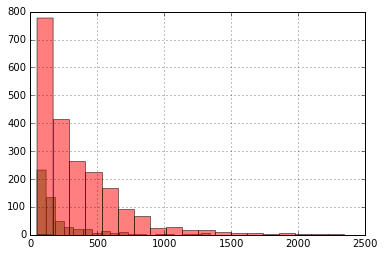

In [385]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['protein_length'].hist(bins=20,alpha=0.5, color='g')
no_filtered_blast_sdf['Pst_E104_v1_p_ctg']['protein_length'].hist(bins=20,alpha=0.5, color='r')

In [400]:
len(no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['exonerate_hit'] == False])/15000

0.023866666666666668

In [44]:
len(nfb_gene_blast_bed_df_filtered[3].unique())

677